In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation, Rescaling
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from pathlib import Path
import cv2
import os
import warnings
import pandas as pd
from collections import deque
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from keras import backend as K

/home/xeth/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-02-01 10:23:31.266116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 10:23:31.266228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 10:23:31.372310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been reg

# Loading the Data

## Dataset

https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images

### Background on the dataset (excrept from the dataset source)

<p class="m-5">This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).</p><p> Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.</p><p> For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.<br>
<p>

In [2]:
# hyperparameters
batch_size = 32
lr = 0.0001
imgSize = 150
epochs = 20
numTrainSamples = 1000  # Change later on
numValSamples = 100  # Change later on
LABEL = ["Normal", "Pneumonia"]

Extract the zip file from the dataset mentioned above to a folder named <b>"pneumonia-xray-images"</b> in the current directory

Text(0.5, 1.0, 'Label Distribution')

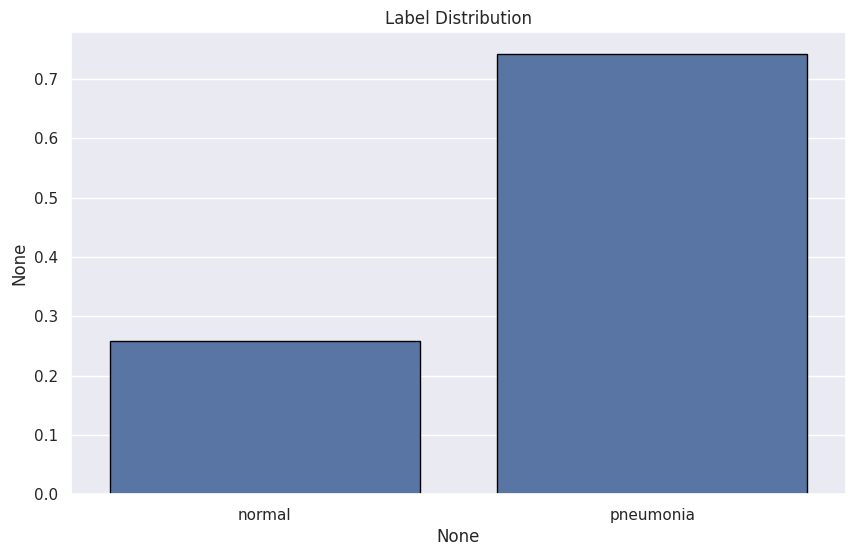

In [3]:
data_dir = Path("./pneumonia-xray-images")


train = data_dir / "train"
val = data_dir / "val"
test = data_dir / "test"

normal = train / "normal"
pneumonia = train / "opacity"


normalFreq = sum(1 for _ in normal.glob("*.jpeg"))
pneumoniaFreq = sum(1 for _ in pneumonia.glob("*.jpeg"))

numTrainSamples = normalFreq + pneumoniaFreq
numValSamples = sum(1 for _ in val.glob("**/*.jpeg"))


pos = sum(1 for _ in (val / "opacity").glob("**/*.jpeg")) + sum(1 for _ in (train / "opacity").glob("**/*.jpeg")) + sum(1 for _ in (test / "opacity").glob("**/*.jpeg"))
neg = sum(1 for _ in (val / "normal").glob("**/*.jpeg")) + sum(1 for _ in (train / "normal").glob("**/*.jpeg")) + sum(1 for _ in (test / "normal").glob("**/*.jpeg"))


labels = pd.Series([*[0]*normalFreq, *[1]*pneumoniaFreq])

sns.set()
fig, ax = plt.subplots(1, figsize=(10,6))
vc = labels.value_counts(normalize=True, sort=False)
labels = pd.Series(vc.values, index=["normal", "pneumonia"])
# labels
count = sns.barplot(x=labels.index, y=labels, edgecolor="black", ax=ax)
count.set_title("Label Distribution")

# plt.savefig("out/proportions.jpg")


In [4]:
train_filenames = tf.io.gfile.glob(str(train / Path('*/*')))
val_filenames = tf.io.gfile.glob(str(val / Path('*/*')))
test_filenames = tf.io.gfile.glob(str(test / Path('*/*')))


train_list = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list = tf.data.Dataset.from_tensor_slices(test_filenames)


2024-02-01 10:23:43.689443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 10:23:43.950075: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 10:23:43.950183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 10:23:43.952811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 10:23:43.952958: I external/local_xla/xla/stream_executor

In [5]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = 0 if parts[-2] == "normal" else 1
    return label


def decode(img):
    # Change image to grayscale and resize it    
    img = tf.image.decode_jpeg(img, channels=1)
    return tf.image.resize(img, (imgSize, imgSize))


def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode(img)
    return img, label



train_ds = train_list.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_list.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = test_list.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)


In [6]:
X_train = []
Y_train = []

X_val = []
Y_val = []

X_test = []
Y_test = []

for image, label in train_ds:
    # print(label.numpy().shape)
    X_train.append(image)
    Y_train.append(label)
    
    
for image, label in val_ds:
    X_val.append(image)
    Y_val.append(label)
    
for image, label in test_ds:
    X_test.append(image)
    Y_test.append(label)
    
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_test, Y_test = np.array(X_test), np.array(Y_test)

print(len(X_train), len(X_val), len(X_test))


4192 1040 624


# Visualizing the Data

# Instances from both classes

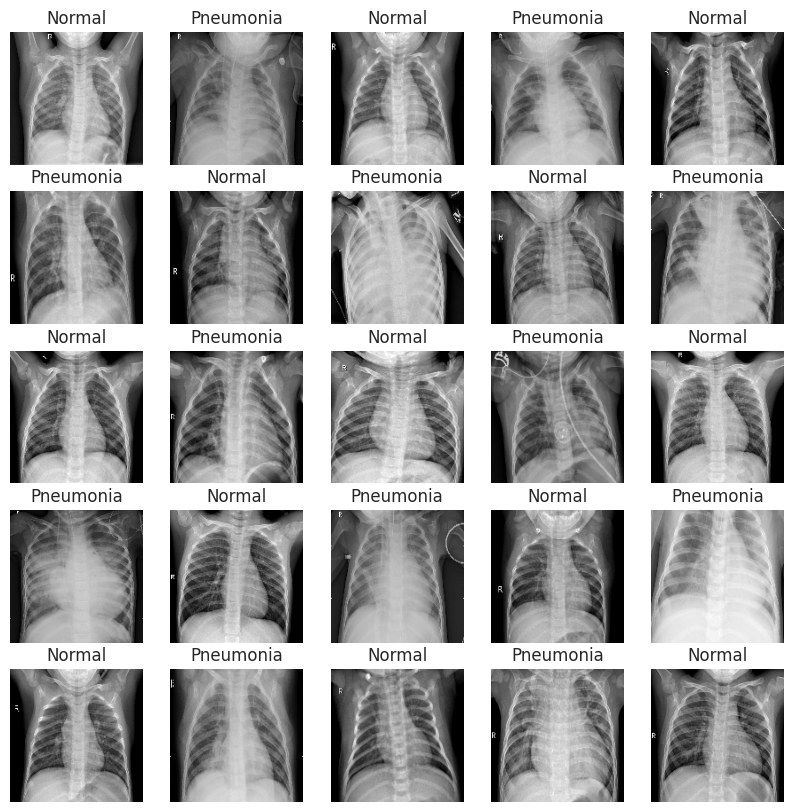

In [7]:
# visualizing the dataset
plt.figure(figsize=(10,10))
for n in range(25):
    image = X_train[((-1)**n)*(n)]
    label = Y_train[((-1)**n)*(n)]
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image, cmap="gray")
    title = "Pneumonia"
    if (label==0): 
        title = "Normal"
    plt.title(title)
    plt.axis("off")

# Data Augmentation

Used techniques like random rotation, random shifiting, random zooming and random flipping to generate "synthetic" data for our training dataset.<br>
This increases the model robustness, mitigates the effects of the data imbalance a little bit and helps reduce overfitting.

Found 4192 images belonging to 2 classes.


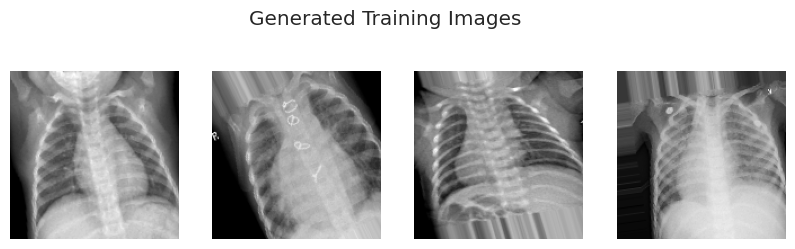

In [8]:

# Data Augmentation
# Creating an ImageGenerator
data_gen = ImageDataGenerator(rescale=1./255,   # Rescale from 0-255 to 0-1
                                   rotation_range=30,  # rondomly rotate training iamges by 30
                                   width_shift_range=0.1,  # randomly shift images horizontally by 10% of width
                                   height_shift_range=0.1,   # randomly shift images horizontally by 10% of height
                                   zoom_range=0.2,  # Randomly zoom in/out 20% into image
                                   horizontal_flip=True)  # Randomly flip image horizontally


data_gen_test = ImageDataGenerator(rescale=1./255)

training_gen = data_gen.flow_from_directory(train, color_mode="grayscale", target_size=(imgSize, imgSize), batch_size=batch_size, class_mode="binary")

# Visualizing the outputs of the generators

fig, axs = plt.subplots(1,4, figsize=(10,3))
fig.suptitle("Generated Training Images")
generated = next(training_gen)
images = generated[0]
for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap="gray")
    ax.axis('off')
    
# fig.savefig("out/Augmented_images.jpg")



# Model Building

Used techniques like random rotation, random shifiting, random zooming and random flipping to generate "synthetic" data for our training dataset.<br>
This increases the model robustness, mitigates the effects of the data imbalance a little bit and helps reduce overfitting.

In [9]:
# Defining metrics we are going to use to track our performance
# We are using these metrics as they better represent our model's generalization compared
# to the traditional accuracy score

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## Building the Model Structure

## Building the Model Structure

In [10]:
model = keras.models.Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape =(imgSize,imgSize,1)))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy', f1_m,precision_m, recall_m, tf.keras.metrics.AUC()])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 75, 75, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                        

Model Architecture Visualization

In [11]:
tf.keras.utils.plot_model(model, to_file="./out/model_architecture.png", show_shapes=True)

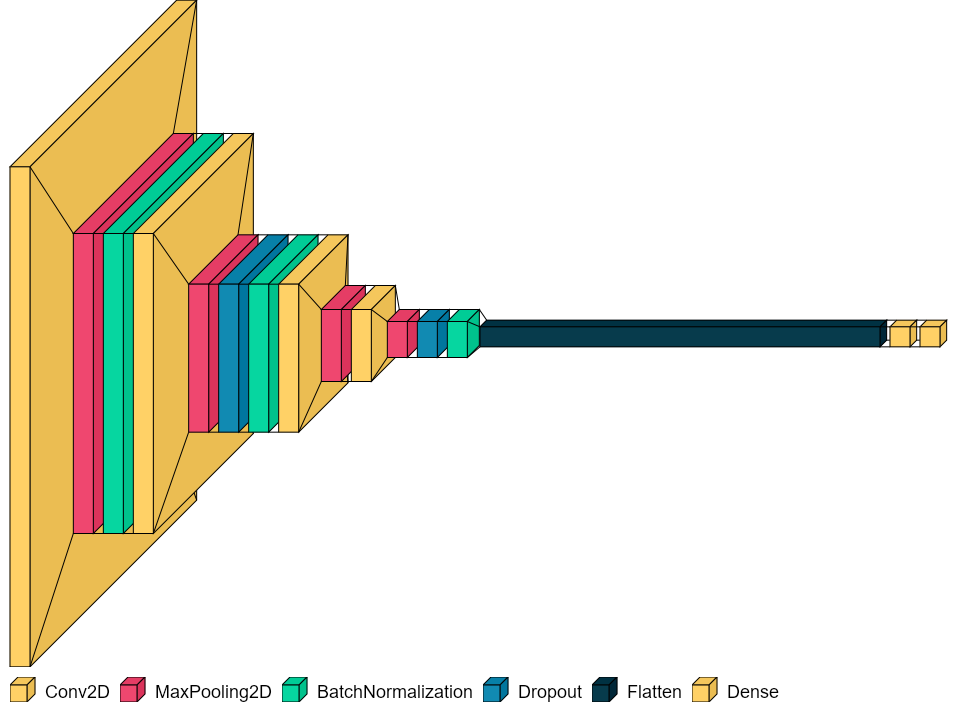

In [ ]:
# Visualization
import visualkeras
from PIL import ImageFont
font = ImageFont.truetype("./arial.ttf", 18)
def getsize(text):
    left, top, right, bottom = font.getbbox(text)
    width = right - left
    height = bottom - top
    return (width, height)
font.getsize = getsize
visualkeras.layered_view(model, legend=True, font=font, max_xy=500)

# Training

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

class_weights = {
    0: 1,
    1: 4
}
checkpoint = tf.keras.callbacks.ModelCheckpoint("saved_models/checkpoint.keras", 
                    monitor="val_loss", mode="auto", 
                    save_best_only=True, verbose=0)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', baseline=None, verbose=1, patience=5)
history = model.fit(data_gen.flow(X_train, Y_train, batch_size=batch_size), epochs = epochs ,validation_data = data_gen.flow(X_val, Y_val), class_weight=class_weights,callbacks = [learning_rate_reduction, checkpoint, early_stopping])


Epoch 1/20


2024-02-01 10:24:10.440594: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-01 10:24:10.778137: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-01 10:24:11.217151: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-01 10:24:11.491319: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-01 10:24:14.271045: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2ca8357070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-01 10:24:14.271094: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 10

131/131 [==============================] - 20s 87ms/step - loss: 0.5625 - accuracy: 0.8330 - f1_m: 0.8957 - precision_m: 0.8317 - recall_m: 0.9771 - auc: 0.9178 - val_loss: 4.3734 - val_accuracy: 0.7433 - val_f1_m: 0.8506 - val_precision_m: 0.7443 - val_recall_m: 1.0000 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 11s 81ms/step - loss: 0.4105 - accuracy: 0.8791 - f1_m: 0.9217 - precision_m: 0.8753 - recall_m: 0.9779 - auc: 0.9596 - val_loss: 3.9322 - val_accuracy: 0.7433 - val_f1_m: 0.8505 - val_precision_m: 0.7453 - val_recall_m: 1.0000 - val_auc: 0.5000 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - 11s 87ms/step - loss: 0.3602 - accuracy: 0.8948 - f1_m: 0.9313 - precision_m: 0.8894 - recall_m: 0.9810 - auc: 0.9664 - val_loss: 2.2891 - val_accuracy: 0.7433 - val_f1_m: 0.8514 - val_precision_m: 0.7443 - val_recall_m: 1.0000 - val_auc: 0.5094 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 10s 79ms/step - lo

In [ ]:
# model.load_weights("saved_models/checkpoint.keras")
loss, accuracy, f1_score, precision, recall, AUC = model.evaluate(data_gen_test.flow(X_test, Y_test))
print(loss, accuracy, f1_score, precision, recall, AUC)

 1/20 [>.............................] - ETA: 1s - loss: 0.1422 - accuracy: 0.9375 - f1_m: 0.9545 - precision_m: 0.9545 - recall_m: 0.9545 - auc: 0.9955

20/20 [==============================] - 0s 17ms/step - loss: 0.2951 - accuracy: 0.8942 - f1_m: 0.9146 - precision_m: 0.8821 - recall_m: 0.9529 - auc: 0.9543
0.29510727524757385 0.8942307829856873 0.9146207571029663 0.882133960723877 0.952878475189209 0.954257071018219


## Visualising Testing Results

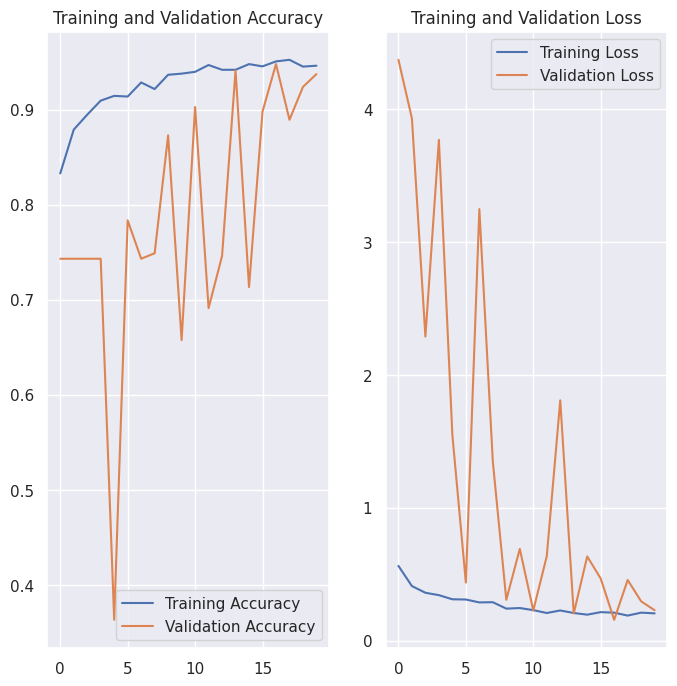

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

eRange = epochs
if early_stopping.stopped_epoch:
    eRange = early_stopping.stopped_epoch+1
    
epochs_range = range(eRange)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')\

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

20/20 [==============================] - 0s 10ms/step


<Axes: >

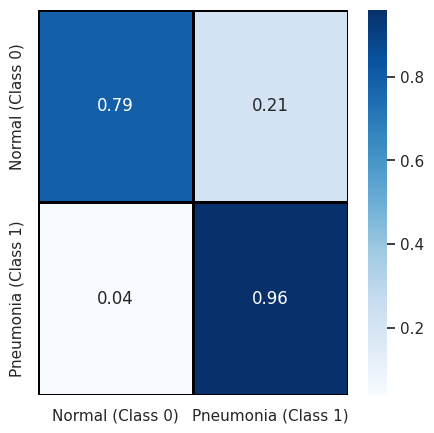

In [ ]:
# model.load_weights("saved_models/Possible_Final_Recall_Update.keras")
classes = ['Normal (Class 0)','Pneumonia (Class 1)']
predictions = model.predict(X_test / 255.)
predictions = predictions.reshape(1,-1)[0]
predictions = np.round(predictions)
cm = confusion_matrix(Y_test.astype(int), predictions, normalize='true')
cm = pd.DataFrame(np.round(cm, decimals=2) , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = classes,yticklabels = classes)
# plt.savefig("./out/Confusion Matrix Unbiased.png")